# Main Analysis Pipeline
 
 * Prepare Hough transform based only on wire information (= energy, time, radial distance)
 * Build predictions based on Hough, local information, and local information of left/right neighbors 

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CyDetHits, CTHHits, CDCHits, FlatHits
from memory_profiler import memory_usage
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


## Import Signal Hits

In [3]:
file_base = "/vols/comet/users/elg112/ICEDUST"\
            "/local_storage/SimDetectorResponse_tree"\
            "/test_signal_sample/03000014_"
cdc_sig_file = file_base + "cdc_sum_sig.root"
cth_sig_file = file_base + "cth_mc_sig.root"

In [4]:
file_base = "/vols/comet/users/elg112/ICEDUST"\
            "/local_storage/SimDetectorResponse_tree"\
            "/test_signal_sample/100k_"
cdc_sig_file = file_base + "cdc_sum_hits.root"
cth_sig_file = file_base + "cth_mc_hits.root"

In [5]:
these_branches = ["DriftTime","DriftDist"]

In [6]:
import hits

In [7]:
reload(hits)

<module 'hits' from '../modules/hits.pyc'>

In [8]:
from hits import CyDetHits, CTHHits, CDCHits, FlatHits

In [9]:
sig_cth = FlatHits(cth_sig_file,
                  tree="COMETEventsSummary",
                  signal_coding=[1], 
                  hit_type_name="IsSig",
                  prefix="CTHHit.f",
                  branches=["CTHHit.fMCPos.fE",
                            "CTHHit.fChannel",
                            "CTHHit.fCharge"])
print sig_cth.n_events

43087


In [10]:
sig_cdc = CyDetHits(cdc_sig_file, 
                      tree="COMETEventsSummary",
                      signal_coding=[1], 
                      hit_type_name="Track.fTrackID",
                      branches=these_branches)
print sig_cdc.n_events

52639


In [11]:
from cylinder import CyDet
geom = CyDet()
n_events = sig_cth.n_events

### Only keep events with hits in both CTH and CDC

In [12]:
passed_events = np.intersect1d(sig_cth.get_signal_hits()[sig_cth.key_name], 
                               sig_cdc.get_signal_hits()[sig_cdc.key_name])
sig_cdc.trim_hits(sig_cdc.key_name, values=passed_events)
sig_cth.trim_hits(sig_cth.key_name, values=passed_events)
print len(passed_events)

20759


### Smear the hits by the bunch width

In [13]:
random_time_smear = np.random.randint(-50,50, size=len(passed_events))

In [14]:
cdc_time_smear = random_time_smear[sig_cdc.hits_to_events]
cth_time_smear = random_time_smear[sig_cth.hits_to_events]

In [15]:
sig_cdc.data["CDCHit.fMCPos.fE"] += cdc_time_smear
sig_cth.data["CTHHit.fMCPos.fE"] += cth_time_smear

### Add the drift time to the CDC hits

In [16]:
sig_cdc.data["CDCHit.fMCPos.fE"] += sig_cdc.data["CDCHit.fDriftTime"]

## Cuts on the Signal Tracks

In [17]:
# Define cuts to use
n_hits_cut = True
layer_cut = True
timing_cut = True
use_cth_cut = True

### Fiducial Time Window Cuts

In [18]:
if timing_cut:
    # Apply the timing filter
    print "Before timing cut"
    before_cdc_nhits = sig_cdc.n_hits
    before_cth_nhits = sig_cth.n_hits
    print "CTH Hits: {}".format(before_cth_nhits)
    print "CDC Hits: {}".format(before_cdc_nhits)
    sig_cth.trim_hits(variable="CTHHit.fMCPos.fE", greater_than=500, less_than=1170)
    sig_cdc.trim_hits(variable=sig_cdc.time_name, greater_than=500, less_than=1620)
    print "After timing cut"
    print "CTH Hits: {0}, {1:.2f}".format(sig_cth.n_hits, float(sig_cth.n_hits)/before_cth_nhits)
    print "CDC Hits: {0}, {1:.2f}".format(sig_cdc.n_hits, float(sig_cdc.n_hits)/before_cdc_nhits)

Before timing cut
CTH Hits: 10020536
CDC Hits: 1812246
After timing cut
CTH Hits: 5127089, 0.51
CDC Hits: 921502, 0.51


In [19]:
passed_events = np.intersect1d(sig_cth.get_events()[sig_cth.key_name], 
                               sig_cdc.get_events()[sig_cdc.key_name])
sig_cdc.trim_hits(sig_cdc.key_name, values=passed_events)
sig_cth.trim_hits(sig_cth.key_name, values=passed_events)
print len(passed_events)

6438


### Cuts on CTH

In [20]:
# Filter for CTH in time window.  Get the time
print sig_cth.n_events
trigger_events = []
for evt in range(sig_cth.n_events):
    sig_hits = sig_cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        trigger_events.append(evt)
trigger_events = np.array(trigger_events)
print "Events that pass CTH Trigger: {}".format(len(trigger_events))

6438
Events that pass CTH Trigger: 5803


### Cuts on CyDet

In [21]:
# Filter for max layer is five
max_layer = []
for evt in range(sig_cdc.n_events):
    these_layers = sig_cdc.geom.point_layers[sig_cdc.get_sig_wires(evt)]
    if len(sig_cdc.get_sig_wires(evt)) != 0:
        max_layer.append(np.max(these_layers))
    else:
        max_layer.append(-1)
max_layer = np.array(max_layer)
good_max_layer = np.where(max_layer >= 4)[0]
print "Passed Max Layer {}".format(len(good_max_layer))

Passed Max Layer 5366


In [22]:
# Filter for number of signal hits
n_signal_hits  = np.array([len(sig_cdc.get_signal_hits(evt)) 
                         for evt in range(sig_cth.n_events)])
n_signal_hits = np.array(n_signal_hits)
good_n_hits = np.where(n_signal_hits >= 30)[0]
print "Passed Good Number of Hits : {}".format(len(good_n_hits))

Passed Good Number of Hits : 5420


### Apply the cuts

In [23]:
if use_cth_cut:
    passed_events = np.intersect1d(passed_events, sig_cth.get_events(trigger_events)[sig_cth.key_name])
    print "Removed due to CTH Trigger {}".format(sig_cth.n_events - len(trigger_events))
if layer_cut:
    passed_events = np.intersect1d(passed_events, sig_cdc.get_events(good_max_layer)[sig_cdc.key_name])
    print "Removed due to Layer Cut {}".format(sig_cdc.n_events - len(good_max_layer))
if n_hits_cut:
    passed_events = np.intersect1d(passed_events, sig_cdc.get_events(good_n_hits)[sig_cdc.key_name])
    print "Removed due to N Hits Cut {}".format(sig_cdc.n_events - len(good_n_hits))

Removed due to CTH Trigger 635
Removed due to Layer Cut 1072
Removed due to N Hits Cut 1018


In [24]:
print "After All Cuts {}".format(len(passed_events))

After All Cuts 4530


In [25]:
sig_cdc.trim_hits(sig_cdc.key_name, values=passed_events)
sig_cth.trim_hits(sig_cth.key_name, values=passed_events)

In [26]:
print sig_cdc.n_events

4530


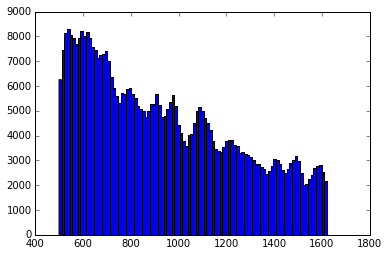

In [27]:
plt.hist(sig_cdc.get_events()[sig_cdc.time_name], bins=100)
show()

## Prepare the data

In [28]:
import pandas
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve

In [29]:
back_sample = "/vols/comet/users/elg112/ICEDUST"\
              "/local_storage/MC3b_tree"\
              "/loose_timing_cut/event_root"\
              "/1_2500_merged_cdc_sum_hit.root"

In [30]:
back_cdc = CyDetHits(back_sample, 
                     tree="COMETEventsSummary",
                     signal_coding=[-1], 
                     hit_type_name="Track.fTrackID",
                     branches=these_branches)

In [31]:
back_cdc.all_branches

['CDCHit.fDriftTime',
 'CDCHit.fDriftDist',
 'CDCHit.fTrack.fTrackID',
 'CDCHit.fEventNumber',
 'CDCHit.fhits_index',
 'CDCHit.fevent_index',
 'CDCHit.fvol_id',
 'CDCHit.fCharge',
 'CDCHit.fMCPos.fE',
 'CDCHit.fTrigTime']

In [32]:
if timing_cut:
    # Apply the timing filter
    print "CyDet Hits: {}".format(back_cdc.n_hits)
    back_cdc.trim_hits(variable=back_cdc.time_name, less_than=1620, greater_than=500)
    print "CyDet Hits: {}".format(back_cdc.n_hits)
    print "Back Events : {}".format(back_cdc.n_events)

CyDet Hits: 3554001
CyDet Hits: 1697759
Back Events : 2494


In [33]:
print len(back_cdc.get_signal_hits())

0


In [41]:
def test_sample(sample):
    # Test 
    passed_events = np.random.randint(0, sample.n_events, sample.n_events/10)
    unique_event_numbers = np.unique(sample.get_events()[sample.key_name])
    passed_events = unique_event_numbers[passed_events]
    print len(passed_events)
    print len(unique_event_numbers)
    print np.amax(sample.hits_to_events)
    print np.amin(sample.hits_to_events)
    print len(np.unique(sample.hits_to_events))
    print sample.n_events
    print sample.n_events - len(unique_event_numbers)
    print sample.n_hits
    print sum(sample.event_to_n_hits)
    print len(sample.get_events())

# Add Hit Merger Feature

In [42]:
from pandas import DataFrame

In [43]:
back_cdc.print_branches()

Branches available are:
CDCHit.fDriftTime
CDCHit.fDriftDist
CDCHit.fTrack.fTrackID
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fMCPos.fE
CDCHit.fTrigTime


In [44]:
print back_cdc.event_to_n_hits
print back_cdc.n_events
print back_cdc.n_hits
print sig_cdc.event_to_n_hits
print sig_cdc.n_events
print sig_cdc.n_hits

[708 622 728 ..., 535 615 644]
2494
1697759
[773 691 797 ...,  64  34  43]
4530
2162161


In [ ]:
sig_cdc.add_hits(back_cdc.data)

In [49]:
delete_with_memory_info([back_cdc])

AttributeError: 'CyDetHits' object has no attribute '__name__'

In [46]:
print back_cdc.event_to_n_hits
print back_cdc.n_events
print back_cdc.n_hits
print sig_cdc.event_to_n_hits
print sig_cdc.n_events
print sig_cdc.n_hits

[708 622 728 ..., 535 615 644]
2494
1697759
[1481 1313 1525 ...,   64   34   43]
4530
3859920


In [47]:
DataFrame(sig_cdc.data)

,CDCHit.fDriftTime,CDCHit.fDriftDist,CDCHit.fTrack.fTrackID,CDCHit.fEventNumber,CDCHit.fhits_index,CDCHit.fevent_index,CDCHit.fvol_id,CDCHit.fCharge,CDCHit.fMCPos.fE,CDCHit.fTrigTime
0,25.639893,0.640997,679,1,0,0,2581,99,502.691406,0
1,25.639893,0.640997,679,1,1,0,2581,99,502.691406,0
2,16.742901,0.418573,679,1,2,0,2324,1505,503.592773,0
3,16.742901,0.418573,679,1,3,0,2324,1505,503.592773,0
4,0.337219,0.008430,679,1,4,0,2323,2977,505.476562,0
5,0.337219,0.008430,679,1,5,0,2323,2977,505.476562,0
6,22.078190,0.551955,679,1,6,0,2322,1157,507.655762,0
7,22.078190,0.551955,679,1,7,0,2322,1157,507.655762,0
8,8.725266,0.218132,619,1,8,0,1823,2057,520.319336,0
9,8.725266,0.218132,619,1,9,0,1823,2057,520.319336,0
